In [1]:
import numpy as  np
import math
import matplotlib.pyplot as plt

# Second round of profiling
Once we get the profiles per layer when entropy threshold is kept constant, do a second round of profiling for accuracte estimates of the tradeoff space

In [2]:
entropies = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

data_pl = {} # e -> [exit_layer_count, eval_times, actual_cost/full_cost, accuracy_per_layer]
for e in entropies:
    data_pl[e] = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/entropy_{}.npy'.format(e), allow_pickle=True)

In [5]:
print(len(data_pl))

13


In [3]:
acc_buckets = {}
# for acc in range(55, 100, 5):
#     acc_buckets[acc] = []

for e in entropies:
    for exit_layer in data_pl[e][3]:
        acc = int(data_pl[e][3][exit_layer] * 20) * 5
        if acc >= 55:
            if acc not in acc_buckets:
                acc_buckets[acc] = []
            latency = int(data_pl[e][1][exit_layer] * 1000)
            exit_layer_count = data_pl[e][0][exit_layer]
            acc_buckets[int(acc/5)*5].append((latency, exit_layer, e, exit_layer_count))

for acc in acc_buckets:
    print(acc, sorted(acc_buckets[acc]))

90 [(21, 1, 0.5, 107), (32, 2, 0.3, 299), (35, 2, 0.2, 200), (48, 3, 0.05, 54), (92, 6, 0.15, 102), (96, 6, 0.2, 96), (99, 6, 0.05, 89), (102, 7, 0.001, 13), (111, 7, 0.15, 114), (111, 7, 0.3, 89), (120, 8, 0.15, 104), (123, 8, 0.1, 138), (128, 8, 0.2, 82), (177, 12, 0.0, 872)]
100 [(30, 2, 0.01, 8), (32, 2, 0.001, 2), (35, 2, 0.005, 2), (37, 2, 0.05, 54), (47, 3, 0.005, 9), (47, 3, 0.01, 15), (62, 4, 0.005, 23), (65, 4, 0.05, 60), (72, 4, 0.001, 3), (74, 5, 0.005, 9), (78, 5, 0.1, 33), (79, 5, 0.01, 12), (80, 5, 0.001, 7), (80, 5, 0.05, 23), (99, 6, 0.001, 32), (105, 7, 0.005, 46), (119, 8, 0.6, 5), (128, 9, 0.6, 2), (154, 11, 0.15, 2), (156, 11, 0.3, 2), (158, 11, 0.4, 1), (159, 11, 0.001, 15), (175, 11, 0.1, 8), (219, 12, 0.5, 1)]
85 [(16, 1, 0.6, 271), (32, 2, 0.4, 385), (34, 2, 0.5, 421), (47, 3, 0.3, 111), (50, 3, 0.4, 98), (61, 4, 0.15, 90), (64, 4, 0.1, 69), (67, 4, 0.2, 91), (79, 5, 0.3, 50), (87, 5, 0.2, 44), (91, 6, 0.5, 51), (95, 6, 0.4, 58), (95, 6, 0.6, 22), (102, 6, 0.3,

In [5]:
# Accuracy is prioritized. We acheive the highest accuracy possible within the latency budget.
def get_entropies(acc_buckets, targt_accuracy, target_latency, n_layers):
    entropies = [(0, 0, 250)] * n_layers # e, acc, latency
    for acc in acc_buckets:
        if acc < targt_accuracy:
            continue
        for latency, exit_layer, e, _ in acc_buckets[acc]:
            if latency > target_latency:
                continue
            if entropies[exit_layer - 1][1] < acc or (entropies[exit_layer - 1][1] == acc and entropies[exit_layer - 1][2] > latency):
                entropies[exit_layer - 1] = (e, acc, latency)
   
    res = []
    for e, _, _ in entropies:
        res.append(e)
    
    for i in range(len(res) - 1, 0, -1):
        if res[i] != 0:
            res[i] = 1
            break
    return tuple(res)

In [32]:
print(get_entropies(acc_buckets, 91, 50, 12))

(0.4, 0.01, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)


In [6]:
def get_entropies_list(acc_buckets, n_layers):
    entropies_list = set()
    for latency in np.arange(10, 220):
        for accuracy in np.arange(100, 54, -1):
            entropies = (0,) * n_layers
            estimates = get_entropies(acc_buckets, accuracy, latency, n_layers)
            if entropies == estimates or estimates in entropies_list:
                continue
            entropies = estimates
            entropies_list.add(entropies)
    return list(entropies_list)

In [7]:
entropies_list = get_entropies_list(acc_buckets, 12)

In [36]:
print(entropies_list)
es = ""
for v in entropies_list:
    cs = ""
    for x in v:
        cs += str(x) + ","
    es += cs[:-1] + " "
print(es)

[(0.4, 0.01, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0, 0), (0, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 1, 0, 0, 0), (0, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0), (0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0.01, 0.005, 0.005, 0.005, 0.001, 1, 0, 0, 0, 0, 0), (0, 0.01, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0, 0), (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0, 0), (0.4, 0.01, 0.005, 1, 0, 0, 0, 0, 0, 0, 0, 0), (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 1, 0, 0, 0, 0, 0), (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 0.001, 1, 0), (0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0), (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 0.001, 0.15, 1), (0, 0.01, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 0, 1, 0), (0, 0.01, 0.005, 1, 0, 0, 0, 0, 0, 0, 0, 0), (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 1, 0, 0, 0), (0, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0, 0), (0

In [8]:
data_entropy = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_1_0.0.npy'.format(e), allow_pickle=True)

In [16]:
print(data_entropy[0:4])

[{1: 40, 2: 3, 3: 6, 4: 15, 5: 808, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}
 {1: 0.002127718925476074, 2: 0.003466924031575521, 3: 0.004784584045410156, 4: 0.012199195226033528, 5: 0.00744202733039856, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}
 0.39793577981651373
 {4: np.float64(1.0), 1: np.float64(0.95), 5: np.float64(0.7821782178217822), 3: np.float64(1.0), 2: np.float64(1.0)}]


In [18]:
trade_off_space = {}
for i in range(len(entropies_list)):
    accuracy = 0
    latency = 0
    max_latency = 0
    count = 0
    for layer in range(1, 13):
        if layer in data_entropy[4*i+3]:
            accuracy += data_entropy[4*i][layer] * data_entropy[4*i+3][layer]
            latency += data_entropy[4*i][layer] * data_entropy[4*i+1][layer]
            max_latency = max(max_latency, data_entropy[4*i+1][layer])
            count += data_entropy[4*i][layer]
    accuracy /= count
    latency /= count
    accuracy = round(accuracy * 100)
    latency = round(latency * 1000)
    max_latency = round(max_latency * 1000)
    trade_off_space[(accuracy, latency, max_latency)] = entropies_list[i]

{(80, 7, 12): (0.4, 0.01, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0, 0), (89, 9, 10): (0, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 1, 0, 0, 0), (84, 7, 14): (0, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0), (92, 13, 14): (0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (78, 3, 3): (0.4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (86, 8, 9): (0, 0.01, 0.005, 0.005, 0.005, 0.001, 1, 0, 0, 0, 0, 0), (80, 7, 10): (0, 0.01, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0, 0), (88, 8, 11): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0, 0), (79, 5, 5): (0, 0.01, 0.005, 1, 0, 0, 0, 0, 0, 0, 0, 0), (86, 10, 12): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 1, 0, 0, 0, 0, 0), (89, 9, 13): (0, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 0, 0.15, 1), (84, 7, 11): (0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0), (79, 4, 4): (0, 0.01, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), (89, 11, 15): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 1, 0, 0), (89, 8, 11): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 1,

In [24]:
accuracies = []
latencies = []
tail_latencies = []
for accuracy, latency, max_latency in trade_off_space:
    print(f'({accuracy}, {latency}, {max_latency}): {trade_off_space[(accuracy, latency, max_latency)]}')
    accuracies.append(accuracy)
    latencies.append(latency)
    tail_latencies.append(max_latency)

(80, 7, 12): (0.4, 0.01, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0, 0)
(89, 9, 10): (0, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 1, 0, 0, 0)
(84, 7, 14): (0, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0)
(92, 13, 14): (0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(78, 3, 3): (0.4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(86, 8, 9): (0, 0.01, 0.005, 0.005, 0.005, 0.001, 1, 0, 0, 0, 0, 0)
(80, 7, 10): (0, 0.01, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0, 0)
(88, 8, 11): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0, 0)
(79, 5, 5): (0, 0.01, 0.005, 1, 0, 0, 0, 0, 0, 0, 0, 0)
(86, 10, 12): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 1, 0, 0, 0, 0, 0)
(89, 9, 13): (0, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 0, 0.15, 1)
(84, 7, 11): (0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0, 0)
(79, 4, 4): (0, 0.01, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(89, 11, 15): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 1, 0, 0)
(89, 8, 11): (0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 1, 0, 0, 0)
(88, 

<Figure size 1000x600 with 0 Axes>

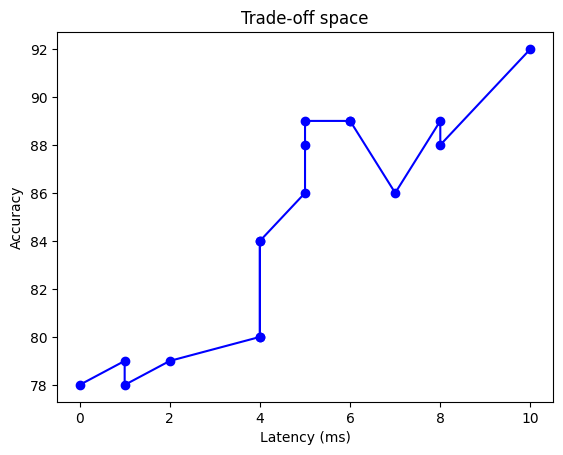

In [28]:
min_latency = np.min(latencies)
max_latency = np.max(latencies)
latencies = (10 * (latencies - min_latency) / (max_latency - min_latency))

data = list(zip(latencies, accuracies))
sorted_data = sorted(data, key=lambda x: x[0])
sorted_latencies, sorted_accuracies = zip(*sorted_data)

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.plot(sorted_latencies, sorted_accuracies, marker='o', linestyle='-', color='b')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Accuracy')
ax.set_title('Trade-off space')
plt.show()

<Figure size 1000x600 with 0 Axes>

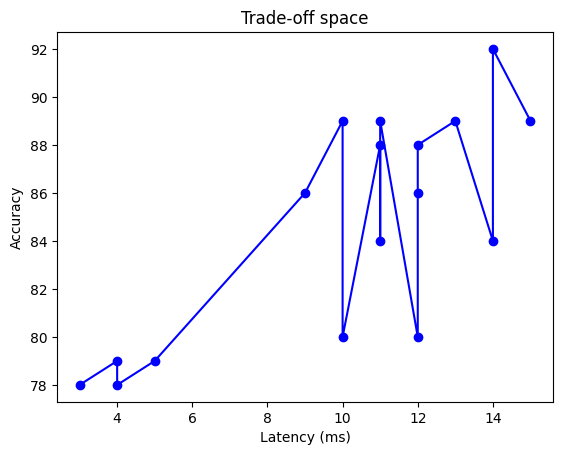

In [25]:
data = list(zip(tail_latencies, accuracies))
sorted_data = sorted(data, key=lambda x: x[0])
sorted_latencies, sorted_accuracies = zip(*sorted_data)

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.plot(sorted_latencies, sorted_accuracies, marker='o', linestyle='-', color='b')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Accuracy')
ax.set_title('Trade-off space')
plt.show()

In [23]:
print(sorted_accuracies)
print(sorted_latencies)

(78, 79, 78, 79, 80, 84, 80, 84, 86, 88, 89, 89, 89, 86, 89, 88, 92)
(3, 4, 4, 5, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11, 13)


In [10]:
temp_Data = np.load('./../plotting2_profile/saved_models/bert_base-SST-2-two_stage/entropy_0.0.npy'.format(e), allow_pickle=True)

In [15]:
temp_Data[44:]

array([{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 872},
       {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0.013488743830164638},
       1.0, {12: np.float64(0.2717889908256881)}], dtype=object)